In [1]:
# Importing the libraries
### !!! IMPORT USEFUL LIBRARIES HERE !!! ###
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt

try:
    # Se esiste __file__, sei in uno script .py
    base_path = os.path.dirname(__file__)
except NameError:
    # Se __file__ non esiste, sei in un notebook
    base_path = os.getcwd()

sys.path.insert(0, os.path.join(base_path, 'utilities'))

from utilities.readExcelData import readExcelData
from utilities.bootstrap import bootstrap 
from utilities.ex1_utilities import business_date_offset, get_discount_factor_by_zero_rates_linear_interp



In [2]:
# Importing the functions from Plots, Calibration, Pricing and Functions modules
from Plots import (compareCopulaVsExact, compareTCopulaVsExact, plot_KL_equity_comparison, plotTranchePricesModel)

from Calibrations import (calibration_model_parameters, find_rho_implied, obj_theta)

from Pricing import (compute_KL_equity_alternative, Price_HP_tstud, Price_HP_vasicek, Price_KL_tstud_fast, Price_KL_vasicek_fast, Price_LHP_tstud, Price_LHP_vasicek, tranchePriceMC_GaussianCopula, tranchePriceMC_tCopula, tranchePriceMC_ArchimedeanCopula)


In [3]:
# --------------------- READ MARKET AND BOOTSTRAP DATA -------------------------
# Read market data from Excel and obtain dates and rates information.
[datesSet, ratesSet] = readExcelData()

# Bootstrap to calculate discount factors based on market data.
dates, discount_factors_appo = bootstrap(datesSet, ratesSet)

# Ensure that the 'Date' column is in datetime format.
dates["Date"] = pd.to_datetime(dates["Date"])

# Create a Series using the 'Discount Factor' column as data and the 'Date' column as the index.
discounts = pd.Series(
    data=discount_factors_appo["Discount Factor"].values,
    index=dates["Date"].values
)

# Set the current date as the settlement date from the datesSet.
today = datesSet.settle

dates_list = dates["Date"].tolist()
dates_list = [pd.to_datetime(d).to_pydatetime() for d in dates["Date"]]



File found and loaded successfully!


In [4]:
data = pd.read_excel("TrancheCorrelations.xlsx", skiprows=1, usecols=[1, 2], names=["Ku", "rho"])
data["Ku"] = pd.to_numeric(data["Ku"])
data["rho"] = pd.to_numeric(data["rho"])

Ku = data["Ku"].to_numpy()
rho = data["rho"].to_numpy()
Kd_allzeros = np.zeros_like(Ku)
Kd = np.zeros_like(Ku)

Kd[1:] = Ku[:-1]



In [5]:
# INPUTS

I = 500                            # Total number of mortgages in the portfolio
p = 0.06                           # Individual default probability for each mortgage
recovery = 0.40                    # Average recovery rate on defaulted mortgages
LGD = 1 - recovery                 # Loss given default
single_notional = 2e6              # Notional exposure per mortgage
notional = single_notional * I     # Total portfolio notional amount
maturity = 4                       # Maturity horizon in years

# Useful variables for the analysis

Ku_e = Ku[0]                     # Upper detachment point for equity tranche
rho_e = rho[0]                   # First correlation (equity tranche)
Kd_e = 0                         # Lower detachment for equity tranche (usually zero)
flag = 'LHP'                     # Model flag used in find_rho_implied
n = len(Ku)                      # Number of tranches considered in total
n_tranches = 3                   # Only 3 tranches for some calculations

expiry = business_date_offset(today, year_offset=maturity)
discount = get_discount_factor_by_zero_rates_linear_interp(today, expiry, discounts.index, discounts.values)

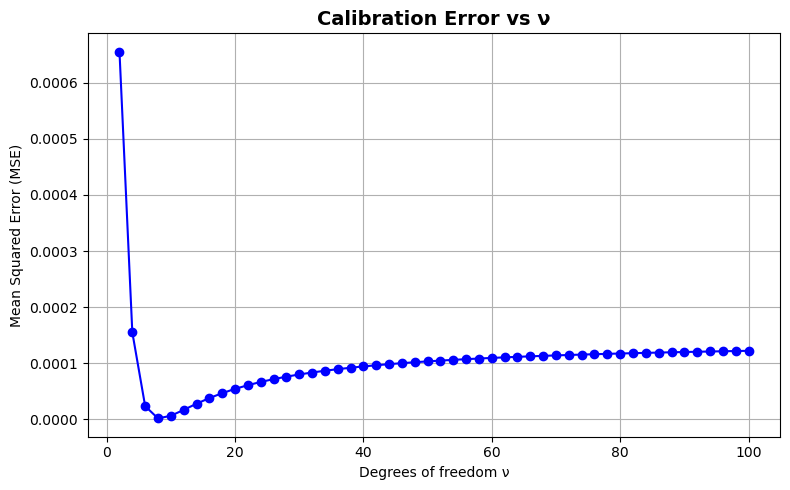


>> Calibration:
 ν optimal (degrees of freedom) = 8.2630
 Mean Squared Error = 0.000002


In [6]:
# Question a): Calibrate the Double t-Student model
# Calibrate correlation parameter and degrees of freedom nu
params = {
    'Ku_vec': Ku,
    'rho_vec': rho,
    'flag_nu': True
}

rho_model, nu_opt, mse_opt, _ = calibration_model_parameters('double_t', params, Ku_e, recovery, rho_e, p, discounts.index, discounts.values)
rho_model_vec = np.full(n, rho_model)  # Model correlation parameter vector

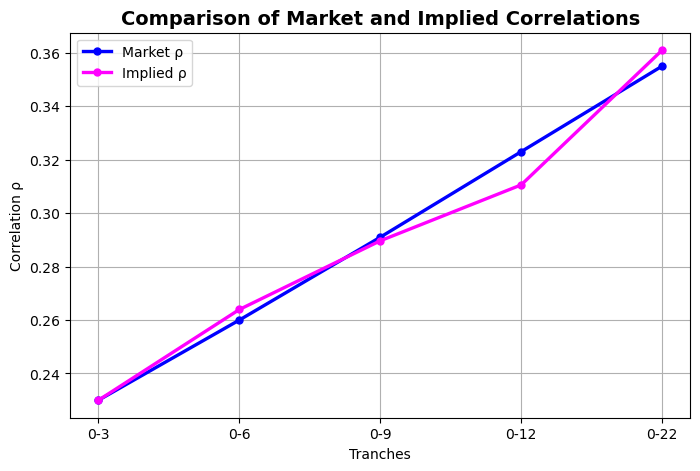

In [7]:
# %% Find implied correlation (rho) for each cumulative tranche from model prices
# Compute tranche prices from calibrated double t-student model 
price_tstudent = Price_LHP_tstud(
    nu_opt, 
    Kd_allzeros, 
    Ku, 
    recovery, 
    rho_model_vec, 
    p, 
    discounts, 
    dates_list
)

rho = np.atleast_1d(rho)
# Find implied rho that equate market price to the calibrated model price (invert Vasicek)
rho_impl_doublet = find_rho_implied(
    Kd_vec = Kd_allzeros, 
    Ku_vec=Ku, 
    recovery=recovery, 
    I=I, 
    rho_vec = rho, 
    p=p, 
    dates=dates["Date"].to_numpy(),
    discounts=discounts.to_numpy(),
    price_model=price_tstudent, 
    flag=flag
)


In [8]:

# %% Question b): Pricing comparison

# 1) Exact pricing under Double t-Student and Vasicek models
# Compute exact prices using the Homogeneous Portfolio assumption (HP)
price_vasicek_exact = Price_HP_vasicek(Kd_allzeros, Ku, recovery, I, rho, p, discounts, dates_list)
price_tstudent_exact = Price_HP_tstud(Kd_allzeros, Ku, nu_opt, recovery, I, rho_model_vec, p, discounts, dates_list)
print(price_vasicek_exact)
print(price_tstudent_exact)


[0.30763724 0.48872683 0.59041092 0.653278   0.74974504]
[0.30828558 0.49060586 0.5900596  0.65127628 0.75013797]


In [9]:

# 2) KL approximation for Double t-Student and Vasicek models
# Compute prices using the Kullback-Leibler (KL) approximation for faster evaluation
price_vasicek_KL = Price_KL_vasicek_fast(Kd_allzeros, Ku, recovery, I, rho, p, discounts, dates_list)
price_tstudent_KL = Price_KL_tstud_fast(Kd_allzeros, Ku, nu_opt, recovery, I, rho_model_vec, p, discounts, dates_list)
print(price_vasicek_KL)
print(price_tstudent_KL)


[0.30813302 0.48905295 0.59067003 0.65350156 0.74988086]
[0.30854372 0.49069527 0.59007994 0.65126068 0.75007284]


In [10]:

# 3) Large Homogeneous Portfolio (LHP) approximation for Double t-Student and Vasicek
# Compute prices using the LHP approximation
price_vasicek = Price_LHP_vasicek(Kd_allzeros, Ku, recovery, rho, p, discounts, dates_list)
price_tstudent = Price_LHP_tstud(nu_opt, Kd_allzeros, Ku, recovery, rho_model_vec, p, discounts, dates_list)
print(price_vasicek)
print(price_tstudent)

[0.30198628 0.48675384 0.58959764 0.65291375 0.74973741]
[0.30198628 0.48865011 0.58922686 0.65082673 0.74996931]


Price Comparison: Vasicek vs t-Student (HP, LHP, KL):
  Tranche  HP_Vasicek  LHP_Vasicek  KL_Vasicek  HP_tStudent  LHP_tStudent  \
0   0 - 3    0.307637     0.301986    0.308133     0.308286      0.301986   
1   0 - 6    0.488727     0.486754    0.489053     0.490606      0.488650   
2   0 - 9    0.590411     0.589598    0.590670     0.590060      0.589227   
3  0 - 12    0.653278     0.652914    0.653502     0.651276      0.650827   
4  0 - 22    0.749745     0.749737    0.749881     0.750138      0.749969   

   KL_tStudent  
0     0.308544  
1     0.490695  
2     0.590080  
3     0.651261  
4     0.750073  


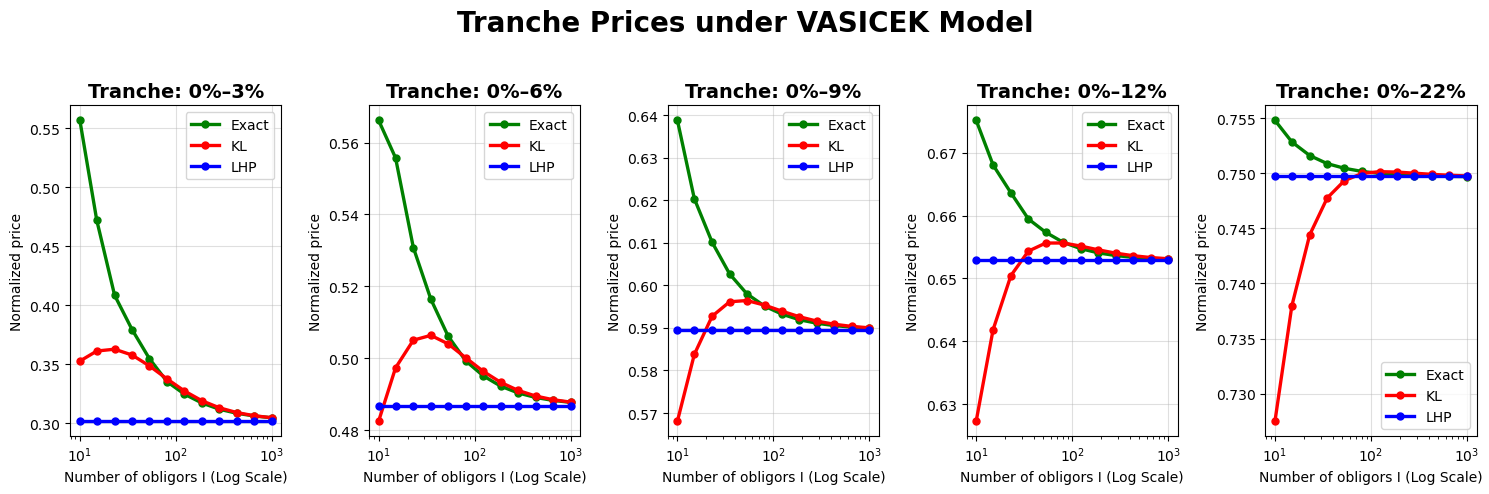

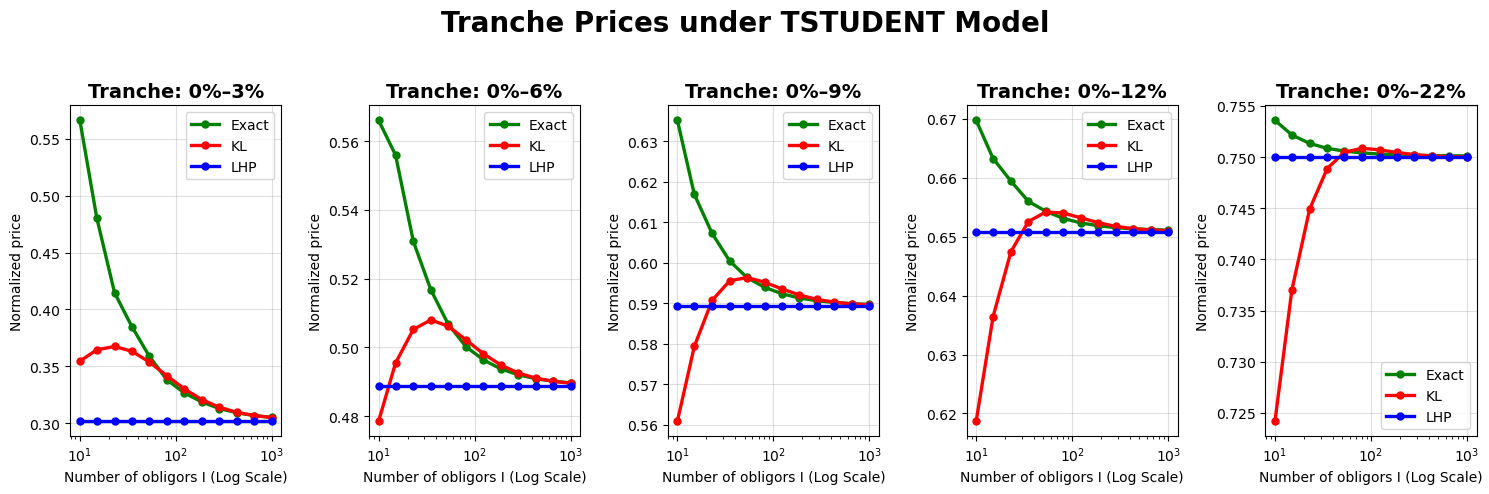

In [11]:

# 4) Compare prices: Vasicek vs Double t-Student
# Summarize all calculated tranche prices in a table for comparison
tranche_labels = ["0 - 3", "0 - 6", "0 - 9", "0 - 12", "0 - 22"]
df_prices = pd.DataFrame({
    'Tranche': tranche_labels,
    'HP_Vasicek': price_vasicek_exact,
    'LHP_Vasicek': price_vasicek,
    'KL_Vasicek': price_vasicek_KL,
    'HP_tStudent': price_tstudent_exact,
    'LHP_tStudent': price_tstudent,
    'KL_tStudent': price_tstudent_KL
})

print("Price Comparison: Vasicek vs t-Student (HP, LHP, KL):")
print(df_prices)
# 5) Plots: Tranche prices with respect to the number of obligors I

# VASICEK: non cumulative tranches
plotTranchePricesModel(
    model_type='vasicek',
    use_shifted=False,
    Kd_vec=Kd_allzeros,
    Ku_vec=Ku,
    recovery=recovery,
    rho_vec=rho,
    nu_opt=nu_opt,
    rho_model_vec=rho_model_vec,
    p=p,
    discounts=discounts,
    dates=dates_list
)



# DOUBLE T-STUDENT: non cumulative tranches
plotTranchePricesModel(
    model_type='tstudent',
    use_shifted=False,
    Kd_vec=Kd_allzeros,
    Ku_vec=Ku,
    recovery=recovery,
    rho_vec=rho,
    nu_opt=nu_opt,
    rho_model_vec=rho_model_vec,
    p=p,
    discounts=discounts,
    dates=dates_list
)



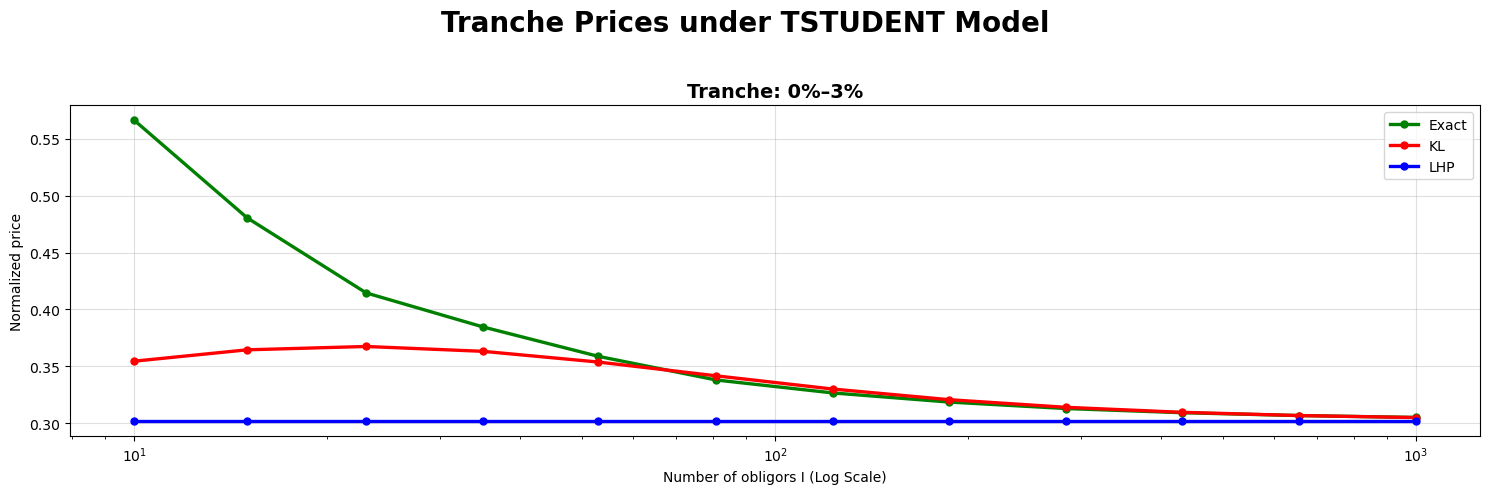

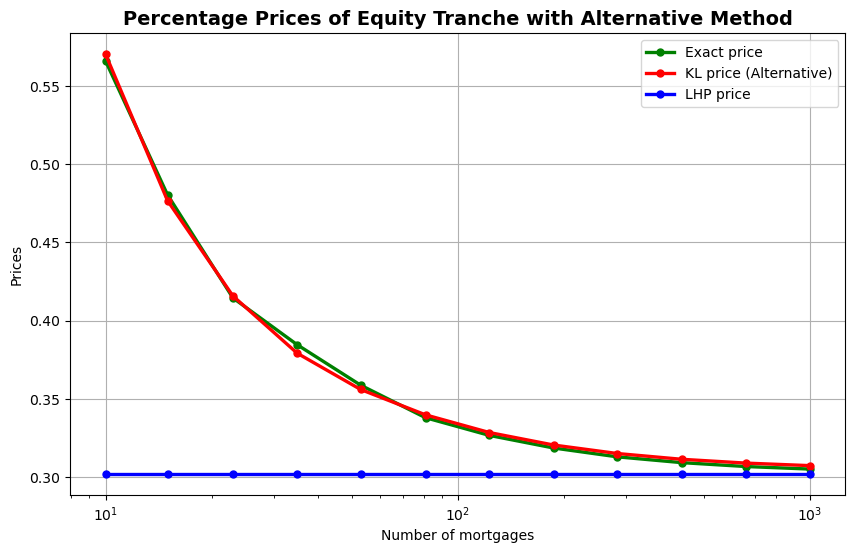

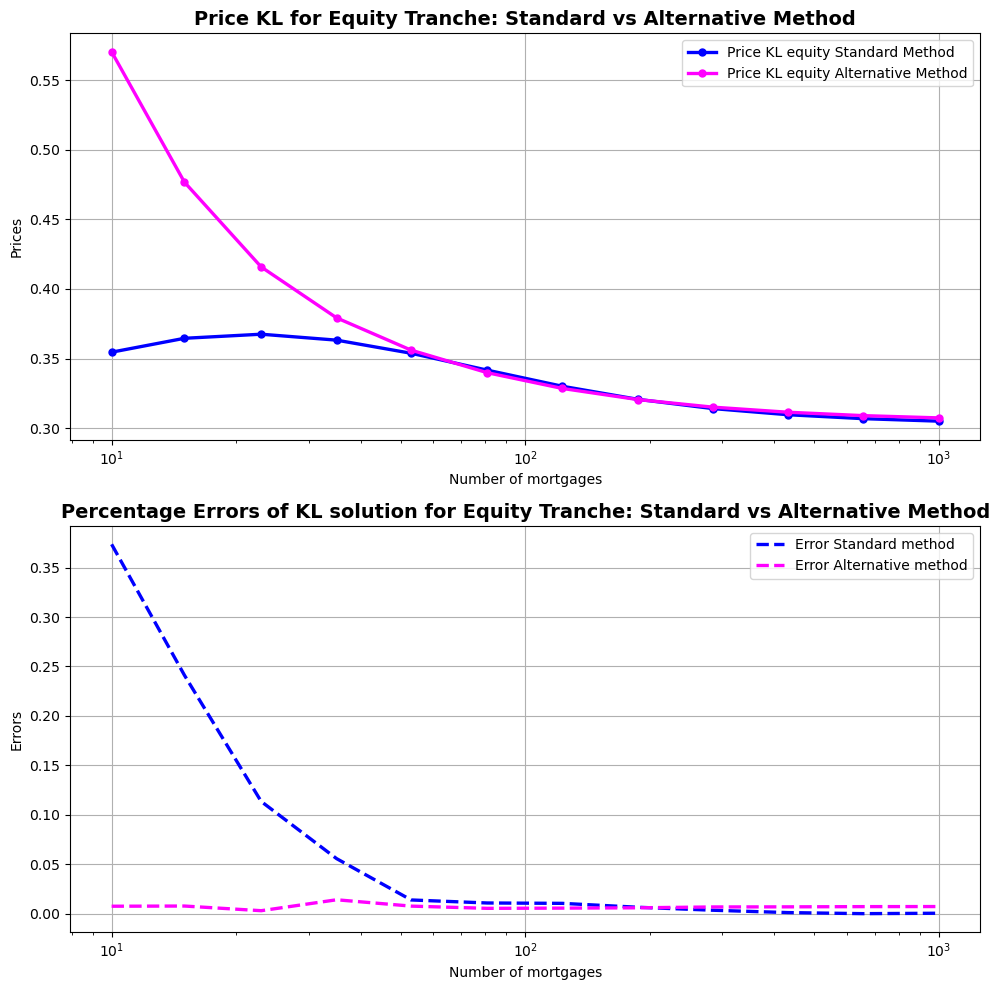

In [12]:
# EQUITY TRANCHE
# Compute equity tranche prices with HP, (standard) KL, LHP solution across different I  
I_values = np.floor(np.logspace(1, np.log10(1000), 12)).astype(int)
price_eq_exact = np.array([
    Price_HP_tstud(Kd_e, Ku_e, nu_opt, recovery, I, rho_model, p, discounts, dates_list)
    for I in I_values])

price_eq_KL = np.array([
    Price_KL_tstud_fast(Kd_e, Ku_e, nu_opt, recovery, I, rho_model, p, discounts, dates_list)
    for I in I_values
])
price_eq_LHP = Price_LHP_tstud(nu_opt, Kd_e, Ku_e, recovery, rho_model, p, discounts, dates_list)

# Plot equity tranche prices under the double t-Student model 
plotTranchePricesModel(
    model_type='tstudent',
    use_shifted=False,
    Kd_vec =Kd_e,
    Ku_vec =Ku_e,
    recovery=recovery,
    rho_vec =rho_model,
    nu_opt =nu_opt,
    rho_model_vec=rho_model_vec,
    p=p,
    discounts=discounts,
    dates=dates_list
)

# Alternative method for KL
# Find the equity price subtracting the total portfolio value by all tranches except the equity (from 3% to 100%)
price_KL_equity_new, price_up_KL, price_ptf = compute_KL_equity_alternative(
    I_values,
    Ku_e,
    Kd_e,
    nu_opt,
    recovery,
    rho_model,
    p,
    discounts,
    dates_list,
    notional,
    discount
)


price_eq_KL = np.array(price_eq_KL).flatten()
price_eq_exact = np.array(price_eq_exact).flatten()
price_KL_equity_new = np.array(price_KL_equity_new).flatten()

# Plot a comparison of different equity tranche pricing methods
plot_KL_equity_comparison(
    I_values,
    price_eq_exact,
    price_eq_KL,
    price_KL_equity_new,
    price_eq_LHP
)


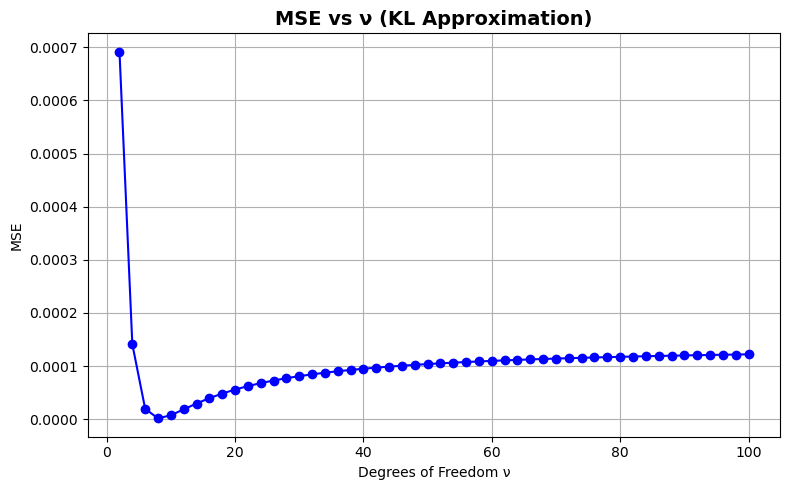


>> Calibration:
 ν optimal (degrees of freedom) = 8.0624
 Mean Squared Error = 0.000001


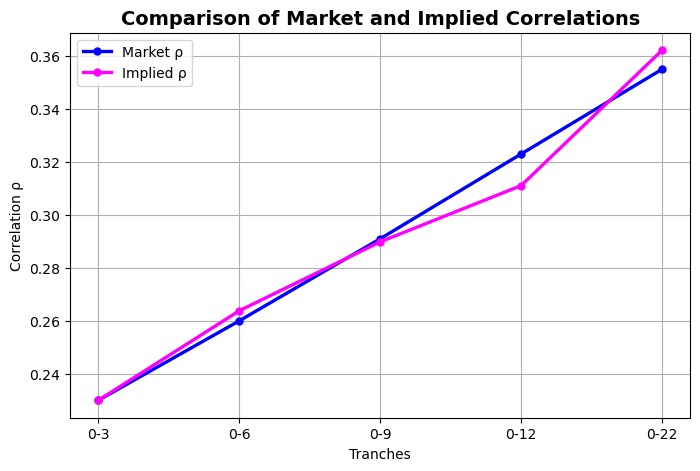

In [13]:
# Question c): KL calibration
# Calibrate correlation parameter and degrees of freedom nu
params = {
    'Ku_vec': Ku,
    'rho_vec': rho,
    'I': I,
    'flag_nu': "true"
}
rho_model_KL, nu_KL_opt, mse_KL_opt, _ = calibration_model_parameters(
    'KL',
    params,
    Ku_e,
    recovery,
    rho_e,
    p,
    dates_list,
    discounts
)
rho_model_KL_vec = rho_model_KL * np.ones((n, 1))  # Model correlation parameter vector

# Find implied correlation (rho) for each cumulative tranche from model prices
# Compute tranche prices from calibrated double t-student model with KL approximation
price_tstudent_KL_calibrated = Price_KL_tstud_fast(
    Kd_allzeros,
    Ku,
    nu_KL_opt,
    recovery,
    I,
    rho_model_KL_vec,
    p,
    discounts,
    dates_list
)

# Find implied rho that equate market price to the calibrated model price (invert Vasicek)
rho_impl_KL = find_rho_implied(
    Kd_allzeros,
    Ku,
    recovery,
    I,
    rho,
    p,
    dates_list,
    discounts,
    price_tstudent_KL_calibrated,
    'KL'
)


In [14]:
# Question d): Price tranches (0-3, 0-6, 0-9) with Vasicek model using correlation rho equal to the implied correlation of the equity tranche.
# Use the implied rho from the equity tranche to price the other tranches
rho_vec_eq = rho_e * np.ones((n_tranches, 1))
price_tranches_rhoequity = Price_LHP_vasicek(
    Kd[:n_tranches],
    Ku[:n_tranches],
    recovery,
    rho_vec_eq,
    p,
    discounts,
    dates_list
)  

print(price_tranches_rhoequity)  # Prices computed with equity implied rho


[0.30198628 0.64217117 0.77499863]


In [15]:

# Question e): Gaussian Copula
# Compare Gaussian copula pricing model against exact pricing
Nsim = int(1e6)

np.random.seed(0) # Set random seed for reproducibility
nMSE_gaussianmodel, nMSE_gaussianmarket, price_copula_model, price_copula_correct, IC_gaussianmodel, IC_gaussianmarket = compareCopulaVsExact(
    Nsim,
    discount,
    rho_model,
    rho,
    p,
    Kd_allzeros[0:n_tranches],
    Ku[0:n_tranches],
    I,
    recovery,
    discounts,
    dates_list,
    tranche_labels
)



Simulation 0 - 3 (1/3)...
Simulation 0 - 6 (2/3)...
Simulation 0 - 9 (3/3)...
               --- Comparison: Gaussian Copula vs Exact (HP) ---                
Tranche           Copula (rho_model) [Lower, Price, Upper]   Copula (rho_market) [Lower, Price, Upper]   Exact (HP)
------------------------------------------------------------------------------------------------------------------------
0 - 3        [  0.349953,   0.350618,   0.351282]   [  0.307549,   0.308177,   0.308804]             0.30763724
0 - 6        [  0.499600,   0.500232,   0.500865]   [  0.488659,   0.489283,   0.489908]             0.48872683
0 - 9        [  0.588247,   0.588814,   0.589381]   [  0.590343,   0.590913,   0.591483]             0.59041092

MSE (Gaussian Copula with rho_model vs Exact):       6.60745278e-04
MSE (Gaussian Copula with rho_market vs Exact):       2.84240521e-07


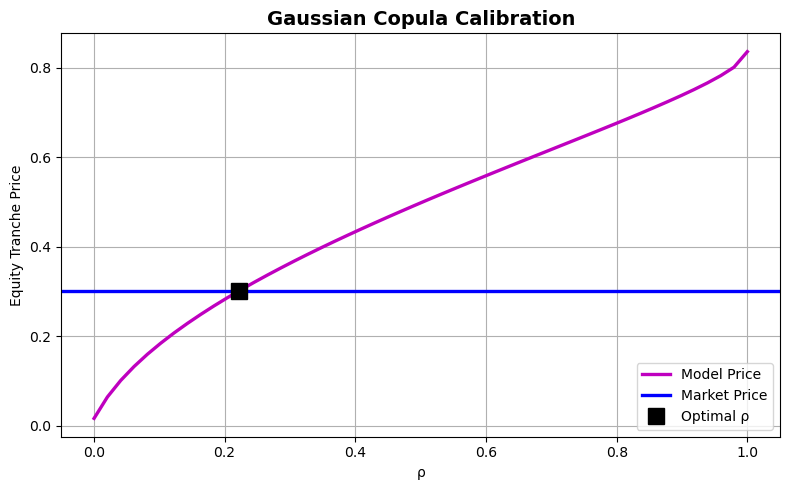

In [16]:
# Calibration of Rho for Gaussian copula
params = {
    'Nsim': Nsim,
    'discount': discount,
    'I': I
}
# Calibrate correlation parameter for the Gaussian copula
rho_gaussian,_,_,_ = calibration_model_parameters(
    'gaussian_copula',
    params,
    Ku_e,
    recovery,
    rho_e,
    p,
    dates_list,
    discounts
)

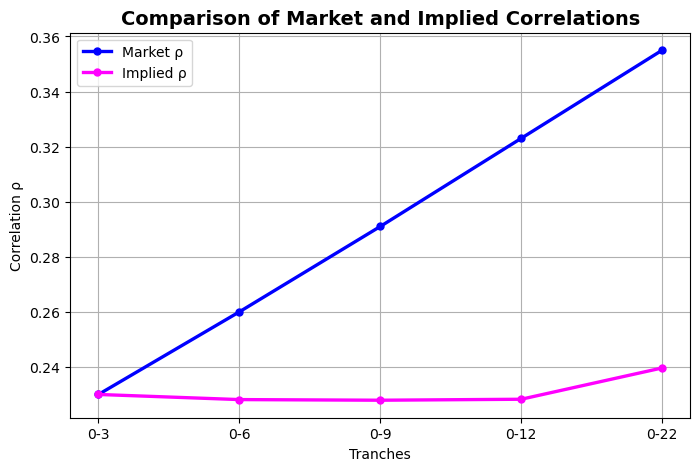

In [17]:
# Find implied correlation (rho) for each cumulative tranche from model prices
# Compute tranche prices from calibrated Gaussian copula model 

price_gaussian_copula = np.zeros(n)
for i in range(n):
    price_gaussian_copula[i],_ = tranchePriceMC_GaussianCopula(
        Nsim,
        discount,
        rho_gaussian,
        p,
        Kd_allzeros[i],
        Ku[i],
        I,
        recovery
    )

# Find implied rho that equate market price to the calibrated model price (invert Vasicek)
rho_impl_gaussian = find_rho_implied(
    Kd_allzeros,
    Ku,
    recovery,
    I,
    rho,
    p,
    dates_list,
    discounts,
    price_gaussian_copula,
    flag
)


Simulation 0 - 3 (1/3)...

Simulation 0 - 6 (2/3)...

Simulation 0 - 9 (3/3)...
                   --- Comparison: t-Copula vs Exact (HP) ---                   
Tranche           Copula (rho_model) [Lower, Price, Upper]   Copula (rho_market) [Lower, Price, Upper]   Exact (HP)
------------------------------------------------------------------------------------------------------------------------
0 - 3        [  0.294394,   0.300325,   0.306256]   [  0.253683,   0.259227,   0.264772]             0.30763724
0 - 6        [  0.477382,   0.483171,   0.488960]   [  0.466569,   0.472266,   0.477963]             0.48872683
0 - 9        [  0.579357,   0.584512,   0.589667]   [  0.581316,   0.586501,   0.591686]             0.59041092

MSE (t-Copula with rho_model vs Exact):        3.97114855e-05
MSE (t-Copula with rho_market vs Exact):       8.76580992e-04


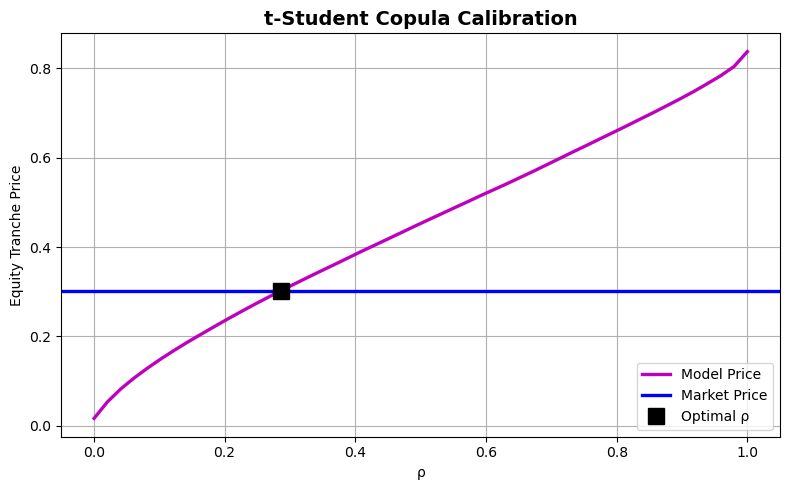

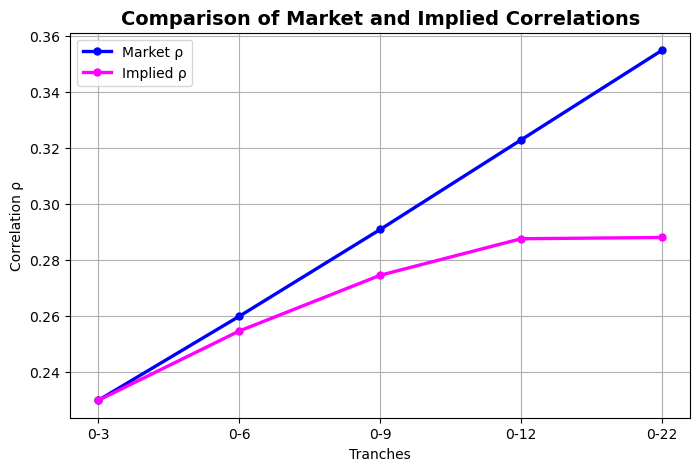

In [18]:
Nsim  = int(1e4)
# EXTRA Analysis: t-Copula vs Exact Pricing
mse_model, mse_market, price_tcopula_model, price_tcopula_correct, IC_tcopulamodel, IC_tcopulamarket = compareTCopulaVsExact(
    tranche_labels,
    Kd_allzeros[:n_tranches],
    Ku[:n_tranches],
    p,
    rho,
    rho_model,
    recovery,
    I,
    nu_opt,
    discounts,
    dates_list,
    Nsim,
    discount
)

# Calibration of Rho for t-Student Copula 
params = {
    'Nsim': Nsim,
    'discount': discount,
    'I': I,
    'nu': nu_opt
}

rho_tstudent,_,_,_ = calibration_model_parameters(
    't_student_copula',
    params,
    Ku_e,
    recovery,
    rho_e,
    p,
    dates_list,
    discounts
)

# Price Tranches Using Calibrated t-Student Copula
price_tstudent_copula = np.zeros(n)
for i in range(n):
    price_tstudent_copula[i],_ = tranchePriceMC_tCopula(
        Nsim,
        discount,
        rho_tstudent,
        p,
        Kd_allzeros[i],
        Ku[i],
        I,
        recovery,
        nu_opt
    )

# Find Implied Rho from t-Copula Tranche Prices
rho_impl_tstudent = find_rho_implied(
    Kd_allzeros,
    Ku,
    recovery,
    I,
    rho,
    p,
    dates_list,
    discounts,
    price_tstudent_copula,
    flag
)



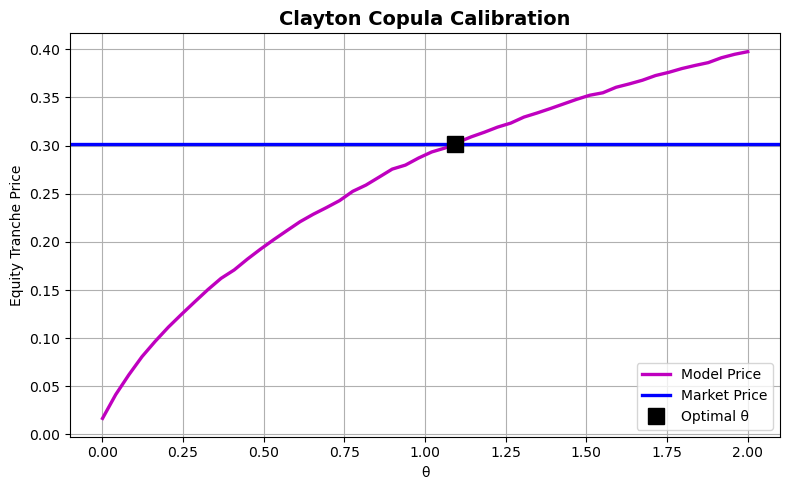

In [19]:

# Clayton Copula Calibration
Nsim = int(1e4)

params = {
    'Nsim': Nsim,
    'discount': discount,
    'I': I
}
theta_opt,_,_,_= calibration_model_parameters(
    'archimedean_copula_clayton',
    params,
    Ku_e,
    recovery,
    rho_e,
    p,
    dates_list,
    discounts
)

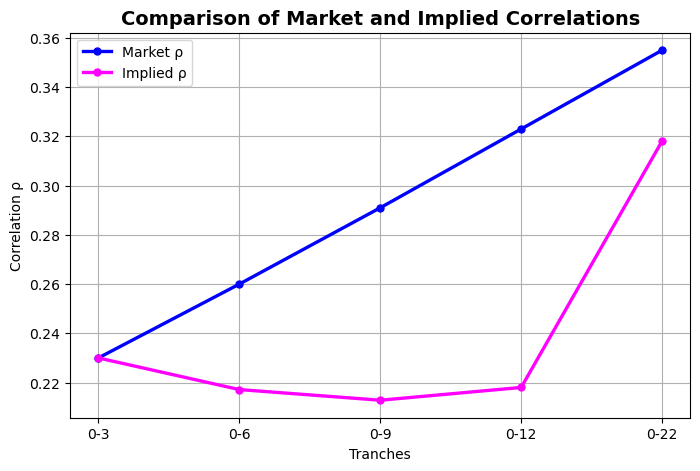

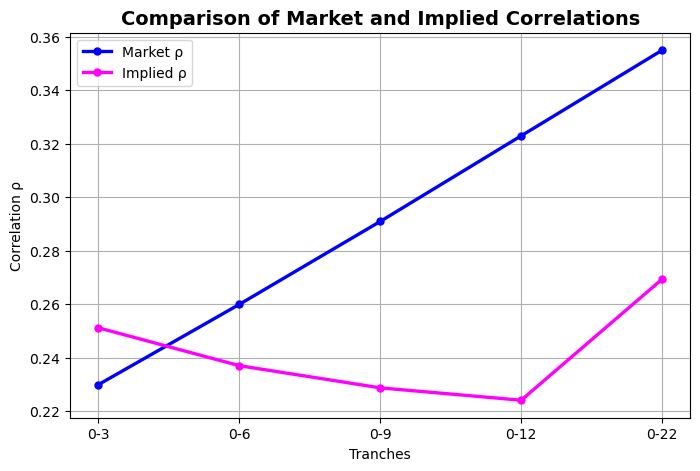

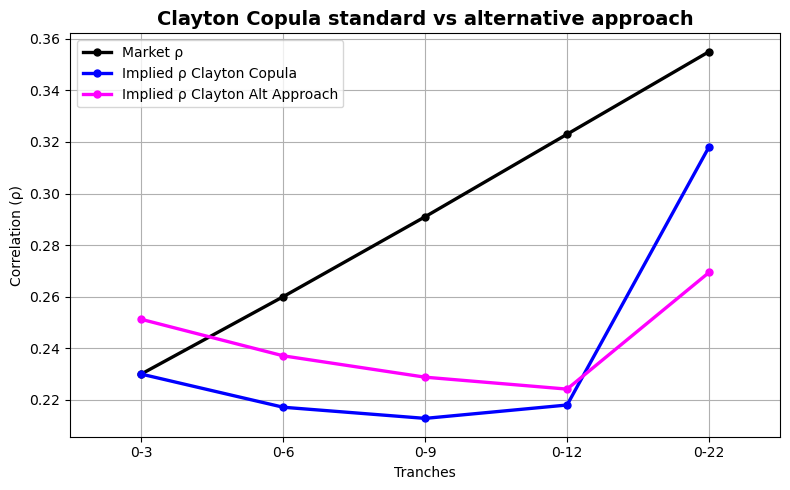

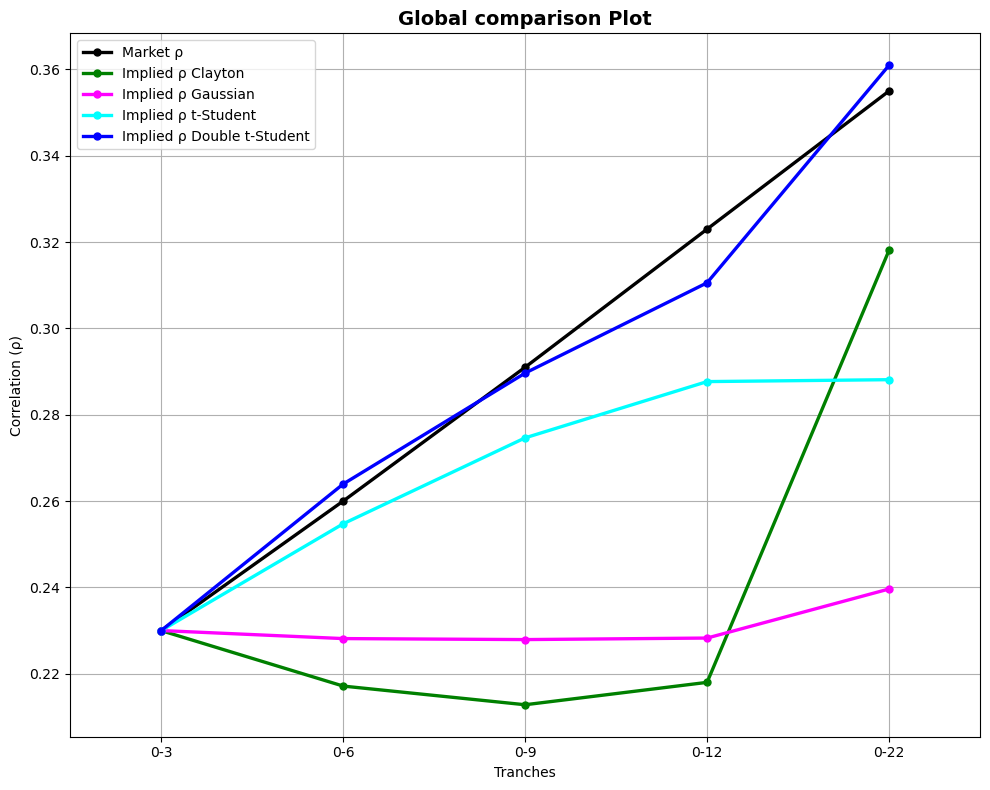

In [20]:

# Tranche Pricing with Calibrated Clayton Copula
price_clayton = np.zeros(n)
for i in range(n):
    price_clayton[i],_ = tranchePriceMC_ArchimedeanCopula(
        Nsim,
        discount,
        p,
        Kd_allzeros[i],
        Ku[i],
        I,
        recovery,
        theta_opt
    )

rho_impl_clayton = find_rho_implied(
    Kd_allzeros,
    Ku,
    recovery,
    I,
    rho,
    p,
    dates_list,
    discounts,
    price_clayton,
    flag
)

# Optimize Theta by Minimizing MSE
obj = lambda theta: obj_theta(price_vasicek, Nsim, discount, p, Kd_allzeros, Ku, I, recovery, theta)
from scipy.optimize import fminbound
theta_opt_mse = fminbound(obj, 0, 10)

price_clayton_mse = np.zeros(n)
for i in range(n):
    price_clayton_mse[i],_ = tranchePriceMC_ArchimedeanCopula(
        Nsim,
        discount,
        p,
        Kd_allzeros[i],
        Ku[i],
        I,
        recovery,
        theta_opt_mse
    )

rho_impl_clayton_mse = find_rho_implied(
    Kd_allzeros,
    Ku,
    recovery,
    I,
    rho,
    p,
    dates_list,
    discounts,
    price_clayton_mse,
    flag
)

# Plot: Clayton Copula - 2 Approaches
x_labels = ['0-3', '0-6', '0-9', '0-12', '0-22']
x = np.arange(1, 6)

plt.figure(figsize=(8, 5))
plt.plot(x, rho, 'o-', color='k', linewidth=2.4, markersize=5, label='Market ρ')
plt.plot(x, rho_impl_clayton, 'o-', color='b', linewidth=2.4, markersize=5, label='Implied ρ Clayton Copula')
plt.plot(x, rho_impl_clayton_mse, 'o-', color='magenta', linewidth=2.4, markersize=5, label='Implied ρ Clayton Alt Approach')
plt.title('Clayton Copula standard vs alternative approach',  fontsize=14, fontweight='bold')
plt.xticks(x, x_labels)
plt.xlim([0.5, 5.5])
plt.xlabel('Tranches')
plt.ylabel('Correlation (ρ)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Global Comparison Plot
plt.figure(figsize=(10, 8))
plt.plot(x, rho, 'o-', color='k', linewidth=2.4, markersize=5, label='Market ρ')
plt.plot(x, rho_impl_clayton, 'o-', color='green', linewidth=2.4, markersize=5, label='Implied ρ Clayton')
plt.plot(x, rho_impl_gaussian, 'o-', color='magenta', linewidth=2.4, markersize=5, label='Implied ρ Gaussian')
plt.plot(x, rho_impl_tstudent, 'o-', color='cyan', linewidth=2.4, markersize=5, label='Implied ρ t-Student')
plt.plot(x, rho_impl_doublet, 'o-', color='blue', linewidth=2.4, markersize=5, label='Implied ρ Double t-Student')
plt.title('Global comparison Plot',  fontsize=14, fontweight='bold')
plt.xticks(x, x_labels)
plt.xlim([0.5, 5.5])
plt.xlabel('Tranches')
plt.ylabel('Correlation (ρ)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()